In [407]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

%store -r all_tweets
#nltk.download('punkt')
#nltk.download('stopwords')

In [408]:
# LSA analysis
import re
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
def clean_tweet(tweet):
    tweet = re.sub(r'[^\w\s]','',tweet)
    tweet_tokens = nltk.word_tokenize(tweet)
    tweet_tokens = [word for word in tweet_tokens if not word in stop_words]
    #print(tweet_tokens)
    return(tweet_tokens)

# Filter out retweets and non english tweets
# 
non_rt_tweets = all_tweets[(all_tweets['tweet_text'].str.count("^RT @") == 0)]
print(non_rt_tweets.shape)
non_rt_tweets = non_rt_tweets[(non_rt_tweets['language'].str.count("en") == 1)]
print(non_rt_tweets.shape)
non_rt_tweets['tokenized_tweet'] = non_rt_tweets['tweet_text'].apply(lambda x: clean_tweet(x))


(147643, 16)
(93125, 16)


In [409]:
from sklearn.feature_extraction.text import TfidfVectorizer

non_rt_tweets['cleaned_tweets'] = non_rt_tweets['tokenized_tweet'].apply(lambda x: ' '.join(x))
non_rt_tweets.head()

vectorizer = TfidfVectorizer(stop_words='english', max_features = 2000, max_df = 0.5)
X = vectorizer.fit_transform(non_rt_tweets['cleaned_tweets'])
X.shape

(93125, 2000)

In [414]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=100, algorithm='randomized', n_iter=100, random_state=1)
svd_model.fit(X)
terms = vectorizer.get_feature_names()

topic_dict = {}
for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    if i == 0: 
        print("Topic "+str(i)+": ")
        print(sorted_terms)
    topic_terms = []
    for k in sorted_terms:
        topic_terms.append(k[0])
    topic_dict[i] = topic_terms
    
X_topics = svd_model.fit_transform(X)


Topic 0: 
[('wwg1wga', 0.8150952629707829), ('qanon', 0.2940693510134832), ('saveourchildren', 0.1772571894417853), ('realdonaldtrump', 0.1735420429298841), ('maga', 0.16336909504998512), ('trump2020', 0.16067324314210404), ('trump', 0.12699637589847704), ('thank', 0.07493872535920905), ('god', 0.07192080558488397), ('patriots', 0.07145695776280381)]


In [411]:
def set_top_topic(x):
    if(len(np.where(X_topics[x] == max(X_topics[x]))[0])):
        return(np.where(X_topics[x] == max(X_topics[x]))[0][0])
    else:
        return(np.where(X_topics[x] == max(X_topics[x]))[0])
    
def set_top_topic_score(x):
    if(len(np.where(X_topics[x] == max(X_topics[x]))[0])):
        return(round(max(X_topics[x]),4))
    else:
        return(round(max(X_topics[x]),4))
    
non_rt_tweets['top_topic'] = [set_top_topic(i) for i in range(0,len(X_topics))]
non_rt_tweets['top_topic_score'] = [set_top_topic_score(i) for i in range(0,len(X_topics))]
non_rt_tweets['topic_desc'] = non_rt_tweets['top_topic'].apply(lambda x: topic_dict[x])

1170


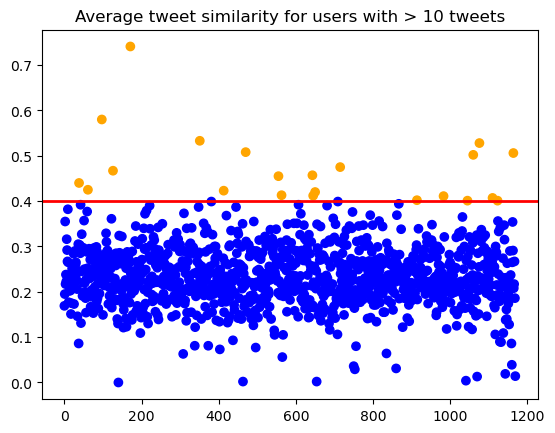

,user_id,avg_num_mentions,avg_num_links,follower_ratio,avg_num_hashtags,retweet_unique_proportion,avg_similarity,similarity_label
0,1457101,0.069,1.00,0.529,0.690,0.030,0.169,Low similarity
1,9114952,0.600,0.76,2.103,0.600,0.400,0.195,Low similarity
2,10219102,0.000,1.00,0.570,2.706,0.000,0.355,Low similarity
3,12014232,0.000,1.00,1.000,6.818,0.000,0.217,Low similarity
4,14542994,1.189,1.00,0.907,4.730,0.481,0.238,Low similarity


In [412]:
from scipy.stats import ttest_1samp
from scipy import stats

non_rt_tweets['num_mentions'] = all_tweets['tweet_text'].str.count("@")
non_rt_tweets['num_links'] = all_tweets['tweet_text'].str.count('http')
non_rt_tweets['follower_ratio'] = all_tweets['num_followers'] / (all_tweets['num_following']+1)
non_rt_tweets['num_hashtags'] = all_tweets['tweet_text'].str.count('#')

grouped_users = non_rt_tweets.groupby('user_id')
grouped_users_counts = grouped_users.size().sort_values()

frequent_users = list(grouped_users.size().sort_values().where(grouped_users_counts >= 10 ).dropna().index)

print(len(frequent_users))
frequent_users_grouped = non_rt_tweets[(non_rt_tweets['user_id'].isin(frequent_users))].groupby('user_id')

non_rt_tweets.head()

unique_users = list(frequent_users_grouped.user_id.unique())
user_df = pd.DataFrame(unique_users, columns = ['user_id'])

user_df['avg_num_mentions'] = [round(frequent_users_grouped.get_group(i)["num_mentions"].mean(),3) for i in user_df['user_id']]
user_df['avg_num_links'] = [round(frequent_users_grouped.get_group(i)["num_links"].mean(),3) for i in user_df['user_id']]
user_df['follower_ratio'] = [round(frequent_users_grouped.get_group(i)["follower_ratio"].mean(),3) for i in user_df['user_id']]
user_df['avg_num_hashtags'] = [round(frequent_users_grouped.get_group(i)["num_hashtags"].mean(),3) for i in user_df['user_id']]
all_frequent_user_tweets = all_tweets[(all_tweets['user_id'].isin(frequent_users))].groupby('user_id')
user_df['retweet_unique_proportion'] = [round(all_frequent_user_tweets.get_group(i)['tweet_text'].str.count("^RT @").sum() / all_frequent_user_tweets.get_group(i).shape[0],3) for i in user_df['user_id']]
user_df['avg_similarity'] = [round(frequent_users_grouped.get_group(i)["top_topic_score"].mean(),3) for i in user_df['user_id']]

def set_quartile(x):
    if x >= 0.4:
        return "High similarity"
    else:
        return "Low similarity"

user_df['similarity_label'] = user_df['avg_similarity'].apply(lambda x: set_quartile(x))

plt.title("Average tweet similarity for users with > 10 tweets")
plt.scatter(np.arange(0,len(user_df['avg_similarity'])),user_df['avg_similarity'], 
            color = [('orange' if x > 0.4 else 'blue') for x in user_df['avg_similarity']])
plt.axhline(linewidth=2, color='r', y=0.4)
plt.show()

user_df.head()



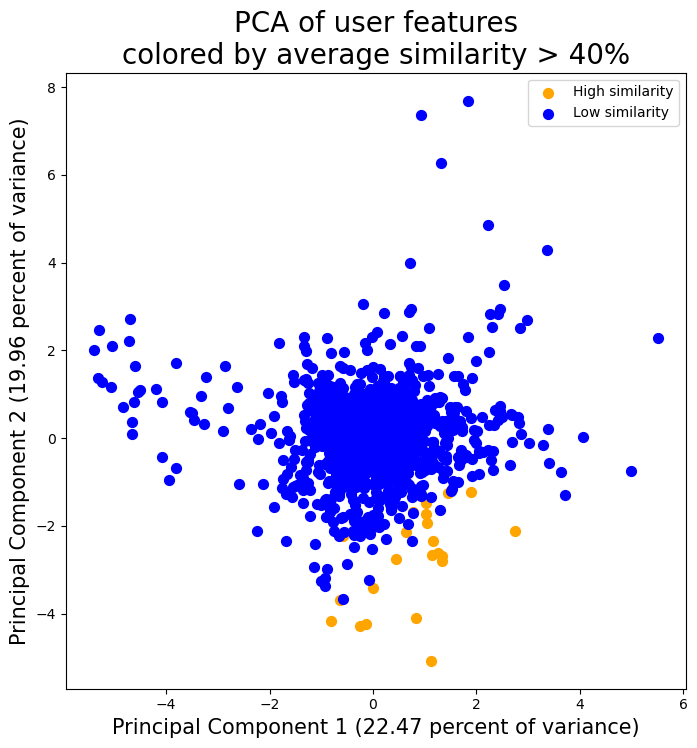

In [400]:

from sklearn.decomposition import PCA

user_colnames = user_df.columns[1:-1]
pca_values = user_df.loc[:,user_colnames]
pca_target = user_df.loc[:,['similarity_label']]

pca_values = StandardScaler().fit_transform(pca_values)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(pca_values)
pca_df = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
pca_df.index = pca_target.index
pca_df = pd.concat([pca_df,pca_target[['similarity_label']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1 (%s percent of variance)'%(round(pca.explained_variance_ratio_[0]*100,2)), fontsize = 15)
ax.set_ylabel('Principal Component 2 (%s percent of variance)'%(round(pca.explained_variance_ratio_[1]*100,2)), fontsize = 15)
ax.set_title('PCA of user features\ncolored by average similarity > 40%', fontsize = 20)
targets = ['High similarity','Low similarity']
colors = ['orange','blue']
for target, color in zip(targets,colors):
    indicesToKeep = pca_df['similarity_label'] == target
    ax.scatter(pca_df.loc[indicesToKeep, 'principal component 1'], pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
ax.legend(targets)


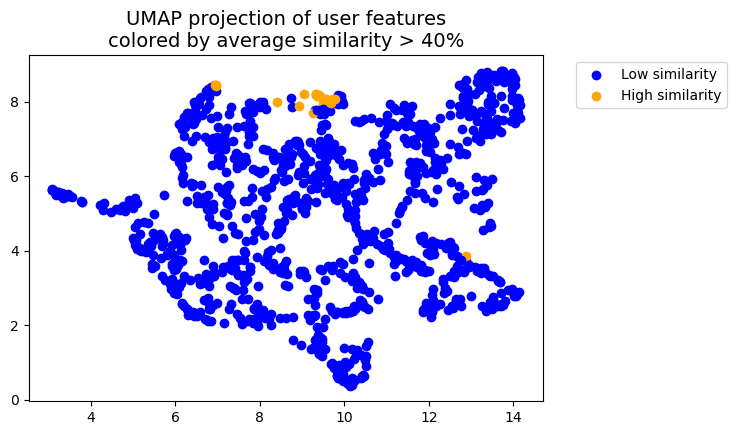

In [401]:
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

reducer = umap.UMAP(random_state=42)

user_data = user_df.loc[:, user_df.columns != 'similarity_label' ]
user_data = user_data.loc[:, user_data.columns != 'user_id' ].values
user_data = StandardScaler().fit_transform(user_data)
embedding = reducer.fit_transform(user_data)

color_map = {"High similarity":'orange', "Low similarity":'blue'}
labelled = {"High similarity":0, "Low similarity":0}

fig = plt.figure(figsize = (7.5,4))
for i in range(0,len(embedding)):
    if not labelled[user_df.at[user_df.index[i],"similarity_label"]]:
        labelled[user_df.at[user_df.index[i],"similarity_label"]] = 1
        plt.scatter(embedding[i,0],embedding[i,1],
                c = color_map[user_df.at[user_df.index[i],"similarity_label"]], 
                label = user_df.at[user_df.index[i],"similarity_label"])
    else:
        plt.scatter(embedding[i,0],embedding[i,1],
                c = color_map[user_df.at[user_df.index[i],"similarity_label"]])

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.title('UMAP projection of user features\ncolored by average similarity > 40%', fontsize=14)
plt.rcParams.update(plt.rcParamsDefault)


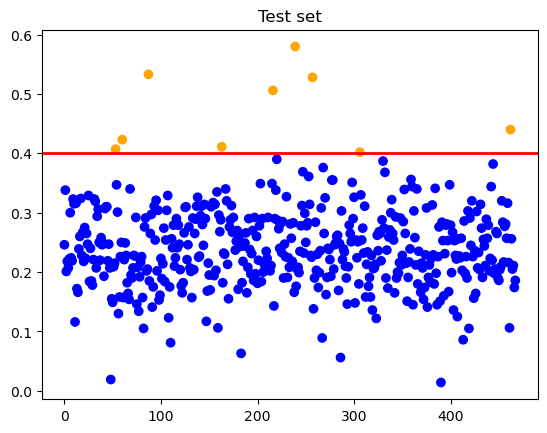

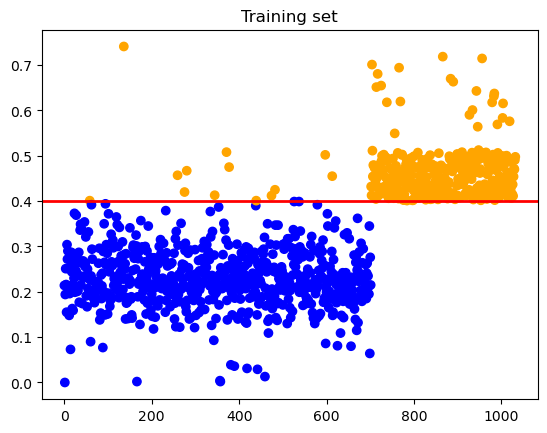

0.8247863247863247
[[2.42838202 3.76074726 0.66121147 0.58261703 2.57701332]]


In [402]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X = user_df.loc[:,user_df.columns[1:-1]]
y = user_df.loc[:,"similarity_label"]

oversample = SMOTE(sampling_strategy = 0.5, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 0)
columns = X_train.columns

oversample_data_X,oversample_data_y = oversample.fit_sample(X_train, y_train)
oversample_data_X = pd.DataFrame(data=oversample_data_X,columns=columns )
oversample_data_y = pd.DataFrame(data=oversample_data_y,columns=['similarity_label'])

oversample_data_X
oversample_data_y

plt.title("Test set")
plt.scatter(np.arange(0,len(X_test['avg_similarity'])),X_test['avg_similarity'], 
            color = [('orange' if x > 0.4 else 'blue') for x in X_test['avg_similarity']])
plt.axhline(linewidth=2, color='r', y=0.4)
plt.show()

plt.title("Training set")
plt.scatter(np.arange(0,len(oversample_data_y['similarity_label'])),oversample_data_X['avg_similarity'], 
            color = [('orange' if x > 0.4 else 'blue') for x in oversample_data_X['avg_similarity']])
plt.axhline(linewidth=2, color='r', y=0.4)
plt.show()

oversample_data_X = oversample_data_X.loc[:, oversample_data_X.columns != "avg_similarity"]
X_test = X_test.loc[:, X_test.columns != "avg_similarity"]

model = LogisticRegression()
model.fit(oversample_data_X, oversample_data_y.values.ravel())
predicted_classes = model.predict(X_test)
accuracy = accuracy_score(y_test,predicted_classes)
parameters = model.coef_

print(accuracy)
print(parameters)

[[  3   6]
 [ 76 383]]
                 precision    recall  f1-score   support

High similarity       0.04      0.33      0.07         9
 Low similarity       0.98      0.83      0.90       459

       accuracy                           0.82       468
      macro avg       0.51      0.58      0.49       468
   weighted avg       0.97      0.82      0.89       468



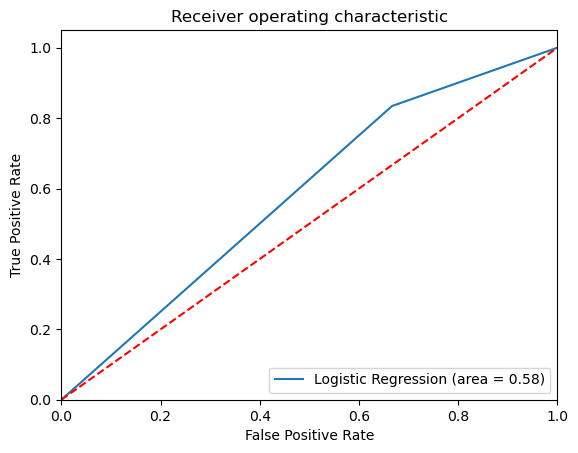

In [403]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

print(confusion_matrix(y_test, predicted_classes))
print(classification_report(y_test, predicted_classes))

y_test_mapped = [(1 if x == "Low similarity" else 0) for x in y_test]
predicted_classes_mapped = [(1 if x == "Low similarity" else 0) for x in predicted_classes]
logit_roc_auc = roc_auc_score(y_test_mapped, predicted_classes_mapped)
logit_roc_auc 
fpr, tpr, thresholds = roc_curve(y_test_mapped, predicted_classes_mapped)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


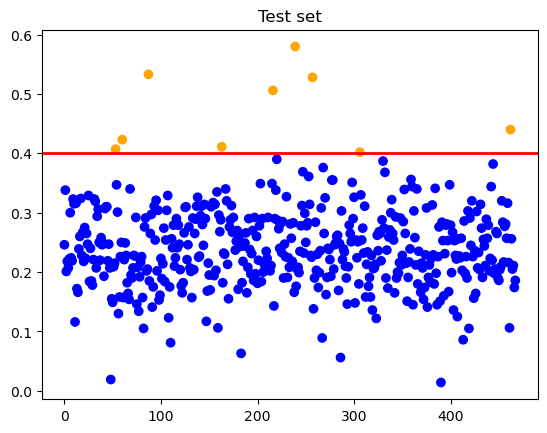

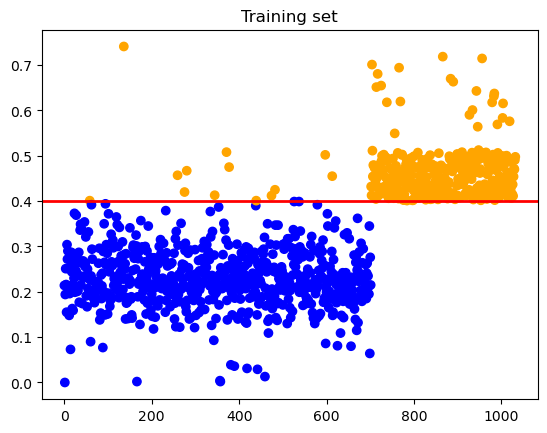

0.967948717948718
[[  1.82944043   2.88447172   0.37111073   0.33092268   1.50112861
  -12.21028218]]


In [404]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 0)
columns = X_train.columns

oversample_data_X,oversample_data_y = oversample.fit_sample(X_train, y_train)
oversample_data_X = pd.DataFrame(data=oversample_data_X,columns=columns )
oversample_data_y = pd.DataFrame(data=oversample_data_y,columns=['similarity_label'])

oversample_data_X
oversample_data_y

plt.title("Test set")
plt.scatter(np.arange(0,len(X_test['avg_similarity'])),X_test['avg_similarity'], 
            color = [('orange' if x > 0.4 else 'blue') for x in X_test['avg_similarity']])
plt.axhline(linewidth=2, color='r', y=0.4)
plt.show()

plt.title("Training set")
plt.scatter(np.arange(0,len(oversample_data_y['similarity_label'])),oversample_data_X['avg_similarity'], 
            color = [('orange' if x > 0.4 else 'blue') for x in oversample_data_X['avg_similarity']])
plt.axhline(linewidth=2, color='r', y=0.4)
plt.show()

model = LogisticRegression()
model.fit(oversample_data_X, oversample_data_y.values.ravel())
predicted_classes = model.predict(X_test)
accuracy = accuracy_score(y_test,predicted_classes)
parameters = model.coef_

print(accuracy)
print(parameters)

[[  6   3]
 [ 12 447]]
                 precision    recall  f1-score   support

High similarity       0.33      0.67      0.44         9
 Low similarity       0.99      0.97      0.98       459

       accuracy                           0.97       468
      macro avg       0.66      0.82      0.71       468
   weighted avg       0.98      0.97      0.97       468



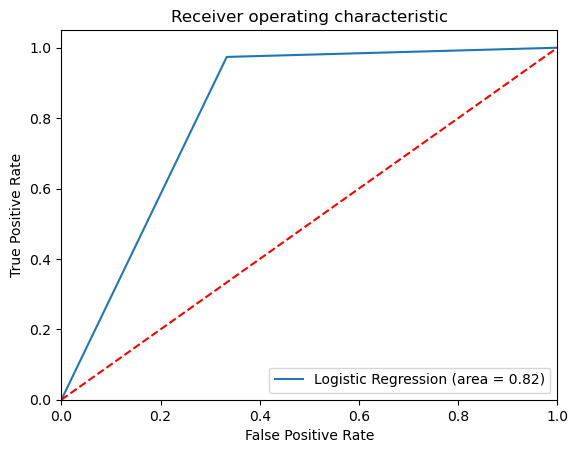

In [405]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

print(confusion_matrix(y_test, predicted_classes))
print(classification_report(y_test, predicted_classes))

y_test_mapped = [(1 if x == "Low similarity" else 0) for x in y_test]
predicted_classes_mapped = [(1 if x == "Low similarity" else 0) for x in predicted_classes]
logit_roc_auc = roc_auc_score(y_test_mapped, predicted_classes_mapped)
logit_roc_auc 
fpr, tpr, thresholds = roc_curve(y_test_mapped, predicted_classes_mapped)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [406]:
print("logit(p) = %s\n + %s*%s + %s*%s\n + %s*%s + %s*%s\n + %s*%s - %s*%s"%(
    round(model.intercept_[0],3), 
    round(model.coef_[0][0],3), columns[0], 
    round(model.coef_[0][1],3), columns[1], 
    round(model.coef_[0][2],3), columns[2], 
    round(model.coef_[0][3],3), columns[3], 
    round(model.coef_[0][4],3), columns[4], 
    round(-1*model.coef_[0][5],3), columns[5]))

logit(p) = 0.085
 + 1.829*avg_num_mentions + 2.884*avg_num_links
 + 0.371*follower_ratio + 0.331*avg_num_hashtags
 + 1.501*retweet_unique_proportion - 12.21*avg_similarity


In [ ]:
# Everything below this chunk is deprecated
# I originally wanted to try to find the underlying mechanisms driving clustering, but without a true
# bot/nonbot metric to classify against, it was not feasible.

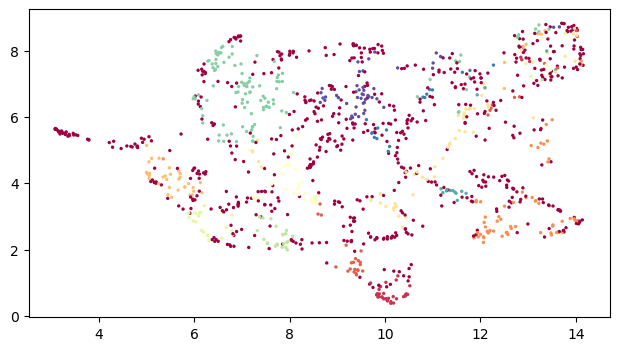

In [350]:
import hdbscan

labels_hdbscan = hdbscan.HDBSCAN(
    min_samples=10
).fit_predict(embedding)

fig = plt.figure(figsize = (7.5,4))
clustered = (labels >= 0)
plt.scatter(embedding[clustered, 0],
            embedding[clustered, 1],
            c=labels_conservative[clustered],
            s=2,
            cmap='Spectral')
plt.show()

plt.rcParams.update(plt.rcParamsDefault)

for i in range(0,len(embedding)):
    user_df.at[user_df.index[i],"cluster_hdbscan"] = labels_hdbscan[i]

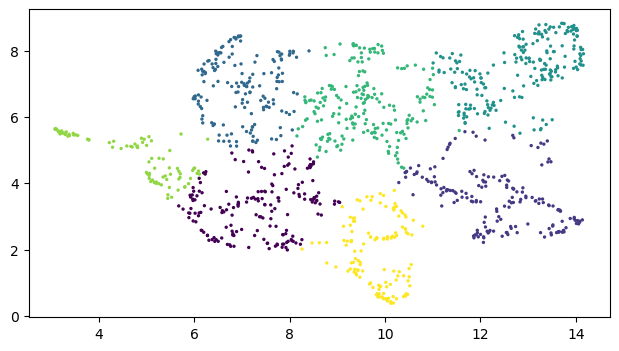

In [351]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=0).fit(embedding)

fig = plt.figure(figsize = (7.5,4))
clustered = (labels >= 0)
plt.scatter(embedding[clustered, 0],
            embedding[clustered, 1],
            c=kmeans.labels_[clustered],
            s=2)
plt.show()

for i in range(0,len(embedding)):
    user_df.at[user_df.index[i],"cluster_kmeans"] = kmeans.labels_[i]

                     feature  importance
5  retweet_unique_proportion       0.310
1              avg_num_links       0.264
0           avg_num_mentions       0.165
4             avg_similarity       0.160
3           avg_num_hashtags       0.092
2             follower_ratio       0.008


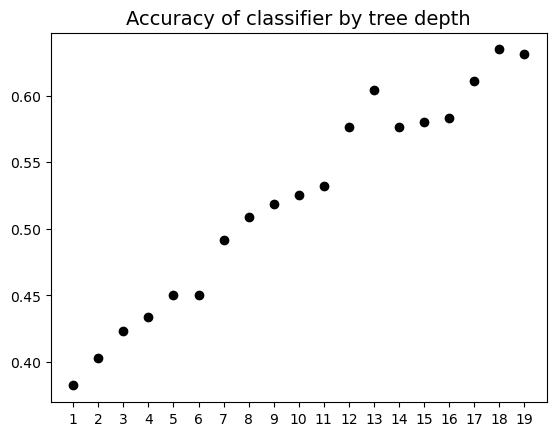

In [256]:
# Building a classifier to determine major features that determine decision making

from sklearn.tree import DecisionTreeClassifier

X_train, X_test, Y_train, Y_test = train_test_split(user_df.loc[:,user_df.columns[1:-3]], user_df['cluster_hdbscan'], random_state=0)

max_depth_range = list(range(1, 20))
for depth in max_depth_range:
    
    tree_classifier = DecisionTreeClassifier(max_depth = depth, 
                             random_state = 0)
    tree_classifier.fit(X_train, Y_train)
    score = tree_classifier.score(X_test, Y_test)
    plt.scatter(depth,score, c = 'black')
    
plt.xticks([x for x in max_depth_range])    
plt.title('Accuracy of classifier by tree depth', fontsize=14)

tree_classifier = DecisionTreeClassifier(max_depth = 9, 
                             random_state = 0)
tree_classifier.fit(X_train, Y_train)

importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(tree_classifier.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
print(importances.head(15))